## makemore: part 4 (backprop ninja)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

In [6]:
# ok biolerplate done, now we get to the action:

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt: torch.Tensor, t: torch.Tensor):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1: torch.Tensor= torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [10]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb]  # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1  # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)  # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact)  # hidden layer
# Linear layer 2
logits = h @ W2 + b2  # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1  # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
    norm_logits, logit_maxes, logits, h, hpreact, bnraw,
    bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
    embcat, emb
]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3661, grad_fn=<NegBackward0>)

## Exercise 1:
Backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

##### `loss = -logprobs[range(n), Yb].mean()`

In [11]:
print(logprobs.shape)
logprobs[range(n), Yb]  # plucking out the values from each row

torch.Size([32, 27])


tensor([-4.0038, -3.1041, -3.7185, -3.1968, -4.2434, -3.4439, -3.2138, -4.0724,
        -3.1567, -4.3095, -3.0613, -1.6669, -2.8714, -3.0527, -2.9195, -3.2029,
        -3.8922, -3.0940, -3.6493, -3.4853, -2.8710, -3.0203, -4.3420, -3.9962,
        -3.5196, -2.8448, -3.0919, -3.8119, -2.7812, -3.5627, -3.3590, -3.1555],
       grad_fn=<IndexBackward0>)

In [12]:
# in simpler terms: loss = - (a + b + c + ...) / n
# <==>
# dloss/da = -1/n 
# dloss/db = -1/n
# ...
# And the rest of the elements in logprobs don't participate, their gradients are 0

In [13]:
# ==> dloss/dlogprobs:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

##### `logprobs = probs.log()`

In [14]:
# dloss/dprobs = dloss/dlogprobs * dlogprobs/dprobs
dprobs = dlogprobs * (1.0 / probs)

##### `probs = counts * counts_sum_inv`

In [15]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [16]:
# Careful!! Shapes are not equal ([32, 27] vs [32, 1]) so broadcasting happens here. What broadcasting looks like:
# c = a[3x3] * b[3x1]
# a11*b1 + a12*b1 + a13*b1
# a21*b2 + a22*b2 + a23*b2
# a31*b3 + a32*b3 + a33*b3
# c[3x3]
dcounts_sum_inv = (dprobs * counts).sum(1, keepdims=True)

##### `counts_sum_inv = counts_sum**-1`

In [17]:
dcounts_sum = dcounts_sum_inv * -1 * (counts_sum**-2)

##### `probs = counts * counts_sum_inv`
##### `counts_sum = counts.sum(1, keepdims=True)`
##### `counts = norm_logits.exp()`

In [18]:
dcounts = dprobs * counts_sum_inv 

# .sum is like
# a11 + a12 + a13  <==> 1 + 0 + 0
# a21 + a22 + a23  <==> 1 + 0 + 0
# ...
dcounts += dcounts_sum * 1.0 # or torch.ones_like(counts)


# counts = norm_logits.exp()
dnorm_logits = counts * dcounts  # norm_logits.exp() * dcounts 

##### `norm_logits = logits - logit_maxes`
##### `logit_maxes = logits.max(1, keepdim=True).values`

In [19]:
logits.shape

torch.Size([32, 27])

In [20]:
len(logits.max(1, keepdim=True).values)

32

In [21]:
logits.argmax(1)

tensor([ 5,  2, 19, 15, 15, 25, 16,  3, 19,  8, 15,  3, 22, 18, 19,  5,  2,  1,
        22, 19, 15, 19, 22, 22, 23,  5, 22, 20, 24,  6, 24, 13])

In [22]:
# norm_logits = logits - logit_maxes
# logit_maxes = logits.max(1, keepdim=True).values
dlogits = dnorm_logits.clone()  # 1.0 * dnorm_logits
dlogit_maxes = (-1.0 * dnorm_logits).sum(1, keepdims=True)  # BATAL

tmp = torch.zeros_like(logits)
tmp[range(n), logits.argmax(1)] = 1
dlogits += tmp * dlogit_maxes  # EXTRA BATAL
# A.K.'s way for dlogits (2nd branch): dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

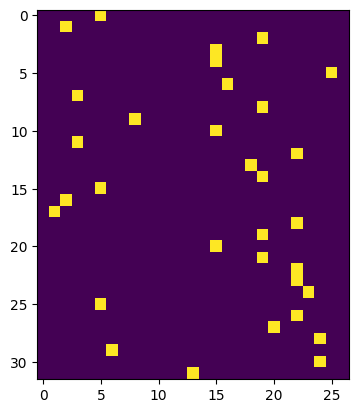

In [23]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

##### `logits = h @ W2 + b2`

In [24]:
logits.shape

torch.Size([32, 27])

In [25]:
b2.shape, dlogits.sum(0).shape

(torch.Size([27]), torch.Size([27]))

In [26]:
h.shape, W2.shape

(torch.Size([32, 64]), torch.Size([64, 27]))

In [27]:
# logits[32x27] = a[32x27] + b[27]
#               = a11 + b1 | a12 + b2 | a13 + b3 | ... | a127 + b27
#               = a21 + b1 | a22 + b2 | a23 + b3 | ... | a227 + b27
#               ...
#               = a321 + b1 | a322 + b2 | a323 + b3 | ... | a3227 + b27

In [28]:
# logits = h @ W2 + b2
db2 =  dlogits.sum(0)  # dlogits.shape is [32x27], b2.shape is [27], need to get rid of 32 (0th dimension)

In [29]:
# h @ W2 

# a11 = b11*c11 + b12*c21 + b13*c31
# a12 = b11*c12 + b12*c22 + b13*c32
# a21 = b21*c11 + b22*c21 + b23*c31
# a22 = b21*c12 + b22*c22 + b23*c32
# a31 = b31*c11 + b32*c21 + b33*c31
# a32 = b31*c12 + b32*c22 + b33*c33

# ==> db11 = da11 * c11 + da12 * c12
# ==> db12 = da11 * c21 + da12 * c22
# ==> db13 = da11 * c31 + da12 * c32
# ==> db21 = da21 * c11 + da22 * c12
# ==> db32 = da31 * c21 + da32 * c22

# THIS IS THE SAME AS:
# db = da @ c.T

# Same for c:
# dc = b.T @ da

In [30]:
h.shape

torch.Size([32, 64])

In [31]:
# dh = torch.zeros_like(h)
# for i in range(dh.shape[0]):
#     for j in range(dh.shape[1]):
#         dh[i, j] = sum(dlog * w2_el for dlog, w2_el in zip(dlogits[i], W2[j]))


In [32]:
dlogits.shape, W2.shape

(torch.Size([32, 27]), torch.Size([64, 27]))

In [33]:
# OR
dh = dlogits @ W2.T

In [34]:
dW2 = h.T @ dlogits

##### `h = torch.tanh(hpreact)`

In [35]:
dhpreact = (1.0 - h**2) * dh

##### `hpreact = bngain * bnraw + bnbias`

In [36]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [37]:
dbnbias = dhpreact.sum(0, keepdims=True)
dbnraw = dhpreact * bngain
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)


##### `bnraw = bndiff * bnvar_inv`
##### `bnvar_inv = (bnvar + 1e-5) ** -0.5`
##### `bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)`
##### `bndiff2 = bndiff**2`

In [38]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [39]:
dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdims=True)

# bnvar_inv = (bnvar + 1e-5) ** -0.5 ==> -0.5 * 1/(bnvar + 1e-5)**1.5
dbnvar = dbnvar_inv * -0.5 * (bnvar + 1e-5)**-1.5

In [40]:
bnvar.shape, bndiff2.shape, dbnvar.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [41]:
# bnvar = 1 / (n - 1) * (bndiff2).sum(0, keepdim=True)
# a1 = 1/(n-1) *  b11 + b12 + b13 ...
# a2 = 1/(n-1) *  b21 + b22 + b23 ...
dbndiff2 =  (1/(n-1)) * dbnvar * torch.ones_like(bndiff2)

# bndiff2 = bndiff**2
dbndiff += (2 * bndiff) * dbndiff2 

##### `bndiff = hprebn - bnmeani`
##### `bnmeani = 1 / n * hprebn.sum(0, keepdim=True)`

In [42]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [43]:
# bndiff = hprebn - bnmeani
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0, keepdims=True)

# bnmeani = 1 / n * hprebn.sum(0, keepdim=True)
dhprebn += torch.ones_like(hprebn) * dbnmeani * 1/n

##### `hprebn = embcat @ W1 + b1`

In [44]:
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [45]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

##### `embcat = emb.view(emb.shape[0], -1)`
##### `emb = C[Xb]`

In [46]:
embcat.shape, emb.shape, C.shape, Xb.shape

(torch.Size([32, 30]),
 torch.Size([32, 3, 10]),
 torch.Size([27, 10]),
 torch.Size([32, 3]))

In [47]:
demb = dembcat.view(emb.shape)

In [48]:
# Xb = [[1, 3], [2, 1], [5, 2]]
# C = [[c11, c12, ...], [c21, c22, ..], [c31, c32, ..], [c41, c42, ..], [c51, 52, ..], [c61, c62, ..]]
# emb = C[Xb] = [
#     [[c11, c12, ...], [c31, c32, ...]],
#     [[c21, c22, ...], [c11, c12, ...]],
#     [[c51, c52, ...], [c21, c22, ...]],
# ]

# In english...
# emb [32x3x10] represents 32 examples, 3 characters with  10 dimensional embeddings each

In [49]:
demb.shape, C.shape, Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [50]:
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        dC[Xb[i, j]] += 1.0 * demb[i, j]
# MEGA BATAL

In [51]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 2.0954757928848267e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw  

# Exercise 2: backprop through cross_entropy but all in one go
to complete this challenge look at the mathematical expression of the loss,
take the derivative, simplify the expression, and just write it out


In [60]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.3660807609558105 diff: 0.0


In [74]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits *= 1/n

In [75]:
cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.05359673500061e-09


In [114]:
# backward pass

# -----------------
# YOUR CODE HERE :)
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits = dlogits / n
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-09


# Exercise 3: backprop through batchnorm but all in one go
to complete this challenge look at the mathematical expression of the output of batchnorm,
take the derivative w.r.t. its input, simplify the expression, and just write it out <br/>
BatchNorm paper: https://arxiv.org/abs/1502.03167


In [76]:
# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [105]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
# dhprebn = None # TODO. my solution is 1 (long) line
dhprebn = (bngain * bnvar_inv) * (
    dhpreact
    - (1/n)*dhpreact.sum(0)
    - (bnraw/(n-1)) * (bnraw * dhpreact).sum(0)
)
# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [106]:
dhpreact.sum(0).shape

torch.Size([64])

# Exercise 4: putting it all together!
Train the MLP neural net with your own backward pass

In [12]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

12297


In [13]:
# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():
    # kick off optimization
    for i in range(max_steps):
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

        # forward pass
        emb = C[Xb]  # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1  # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5) ** -0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact)  # hidden layer
        logits = h @ W2 + b2  # output layer
        loss = F.cross_entropy(logits, Yb)  # loss function

        # backward pass
        for p in parameters:
            p.grad = None
        # loss.backward()  # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)
        # dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
        # cross entropy
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # hidden layer
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        # BatchNorm layer
        dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
        dbnbias = dhpreact.sum(0, keepdims=True)
        dhprebn = (bngain * bnvar_inv) * (
            dhpreact - (1 / n) * dhpreact.sum(0) - (bnraw / (n - 1)) * (bnraw * dhpreact).sum(0)
        )
        # Linear layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                dC[Xb[k, j]] += demb[k, j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad  # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0:  # print every once in a while
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

        # if i >= 100:  # TODO: delete early breaking when you're ready to train the full net
        #     break

      0/ 200000: 3.8245
  10000/ 200000: 2.1715
  20000/ 200000: 2.4006
  30000/ 200000: 2.4569
  40000/ 200000: 1.9962
  50000/ 200000: 2.4305
  60000/ 200000: 2.3470
  70000/ 200000: 2.0743
  80000/ 200000: 2.3341
  90000/ 200000: 2.1615
 100000/ 200000: 1.9239
 110000/ 200000: 2.3310
 120000/ 200000: 1.9826
 130000/ 200000: 2.4293
 140000/ 200000: 2.2704
 150000/ 200000: 2.0950
 160000/ 200000: 1.9071
 170000/ 200000: 1.8234
 180000/ 200000: 2.0095
 190000/ 200000: 1.9261


In [11]:
# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 1.862645149230957e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.122274160385132e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 3.259629011154175e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


In [14]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [15]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071169853210449
val 2.110775947570801


In [16]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayanniee.
mad.
rylle.
emmadiendraeg.
adelynnelin.
shi.
jen.
eden.
estanaraelyn.
malara.
noshubergihamie.
trick.
welle.
jose.
casubekahdi.
jamyleyeks.
kaysh.
samyah.
hal.
